<a href="https://colab.research.google.com/github/Willyzw/SuperPointPretrainedNetwork/blob/master/superpoint_handson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Superpoint Handson
This demo

In [1]:
! git clone https://github.com/Willyzw/SuperPointPretrainedNetwork
% cd /content/SuperPointPretrainedNetwork

Cloning into 'SuperPointPretrainedNetwork'...
remote: Enumerating objects: 81, done.
remote: Total 81 (delta 0), reused 0 (delta 0), pack-reused 81
Unpacking objects: 100% (81/81), done.
/content/SuperPointPretrainedNetwork


In [2]:
import time
import numpy as np
import cv2
import PIL.Image as pil

from IPython.display import clear_output
from demo_superpoint import SuperPointFrontend, PointTracker, VideoStreamer

In [3]:
# This class helps load input images from different sources.
vs = VideoStreamer("assets/nyu_snippet.mp4", camid=0, height=480, width=480, skip=1, img_glob='*.png')

print('==> Loading pre-trained network.')
# This class runs the SuperPoint network and processes its outputs.
fe = SuperPointFrontend(weights_path='superpoint_v1.pth',
                        nms_dist=4,
                        conf_thresh=0.015,
                        nn_thresh=0.7,
                        cuda=False)
print('==> Successfully loaded pre-trained network.')

# This class helps merge consecutive point matches into tracks.
tracker = PointTracker(5, nn_thresh=fe.nn_thresh)


==> Processing Video Input.
==> Loading pre-trained network.
==> Successfully loaded pre-trained network.


Processed image 30 (net+post_process: 1.69 FPS, total: 1.57 FPS).


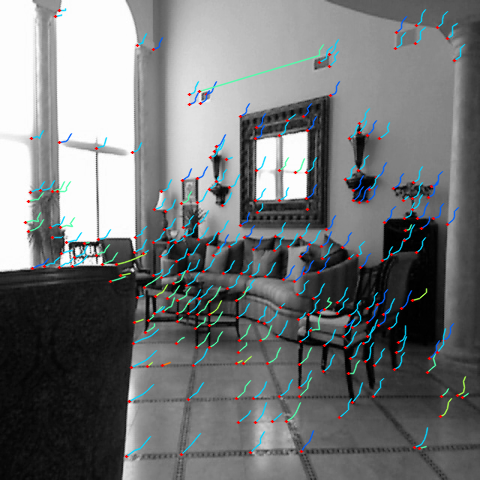

In [4]:
print('==> Running Demo.')
while True:

  start = time.time()

  # Get a new image.
  img, status = vs.next_frame()
  if status is False:
    break

  # Get points and descriptors.
  start1 = time.time()
  pts, desc, heatmap = fe.run(img)
  end1 = time.time()

  # Add points and descriptors to the tracker.
  tracker.update(pts, desc)

  # Get tracks for points which were match successfully across all frames.
  tracks = tracker.get_tracks(2)

  # Primary output - Show point tracks overlayed on top of input image.
  out1 = (np.dstack((img, img, img)) * 255.).astype('uint8')
  tracks[:, 1] /= float(fe.nn_thresh) # Normalize track scores to [0,1].
  tracker.draw_tracks(out1, tracks)

  end = time.time()
  net_t = (1./ float(end1 - start))
  total_t = (1./ float(end - start))

  clear_output(wait=True)
  print('Processed image %d (net+post_process: %.2f FPS, total: %.2f FPS).'\
        % (vs.i, net_t, total_t))
  vis = pil.fromarray(out1)
  display(vis)


In [ ]:
while True:pass